In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import interpolate_outputs

from utility_programs.utils import str_to_ut

from utility_programs.read_routines import SAMI, GITM
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

/mfs/io/groups/phil/aaron/.conda/envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import importlib
import sys
import os
import gc

from tqdm import tqdm

In [4]:
out_path = '/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/'

sami_data_path = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

In [5]:
dtime_sim_start = '20130316'


dtime_sim_start = str_to_ut(dtime_sim_start)


In [6]:
interpolate_outputs = importlib.reload(interpolate_outputs)

In [7]:
allsatdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')

In [8]:
sats = np.unique(allsatdf.sat)

In [9]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(sami_data_path)

grid = SAMI.get_sami_grid(sami_data_path, nlt, nf, nz)


# specify max alt to build delauney at
max_alt = 1100
min_alt = 650

mask = np.where((grid['alt'] < max_alt) & (grid['alt'] > min_alt))
grid2 = {}
for k in grid.keys():
    grid2[k] = grid[k][mask].flatten()

    
in_cart = interpolate_outputs.gps_to_ecef_custom(grid2['glon'],
                                grid2['glat'],
                                grid2['alt']).T



tri = Delaunay(in_cart)



In [10]:
data, times = SAMI.read_to_nparray(
        sami_data_path, dtime_sim_start,
        cols='edens',
        skip_time_check=True)

In [24]:

for sat_num in sats:

    sat_df = allsatdf.loc[allsatdf.sat == sat_num].reset_index(drop=True)
    # print(satnum, len(sat_df))

    latlon = [sat_df.glat, sat_df.glon]
    latlon = np.array(latlon)
    alt = [840 for i in range(len(latlon[0]))]

    latlonalt = (latlon[0], latlon[1], alt)
    latlonalt = np.array(latlonalt)


    latout = latlonalt[0]
    lonout = latlonalt[1]
    altout = latlonalt[2]
    
    out_lon_lat_alt = interpolate_outputs.gps_to_ecef_custom(
        lonout, latout, altout).T
    
    
    first = True  # for choosing which mode to write
    numcol_for_pbar = 1
    
    
    ds =  xr.Dataset(coords={
            'sami_time': (['sami_time'], times),
            'glat': (['sat_time'], latout),
            'glon': (['sat_time'], lonout),
            'sat_time': (['sat_time'], [pd.Timestamp(i) for i in sat_df['dtime']])})
    

    
    ds['e_dens'] = (('sami_time', 'sat_time'),
                        np.zeros([len(times),
                                len(lonout)]))

    for t in range(len(times)):
        interp = LinearNDInterpolator(
            tri,
            data['data']['edens'][:, :, :, t][mask].flatten())


        ds['e_dens'][t] = interp(out_lon_lat_alt)
    


            
            
    ds.to_netcdf(out_path+'F%i.nc' %sat_num, engine='h5netcdf')
    
    print(out_path+'F%i.nc' %sat_num, 'written')
    

/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/F16.nc written
/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/F17.nc written
/petastore/phil/Prasoon_satellite_project/sat_files_for_phil/20130317/F18.nc written


In [45]:
ds.sami_time

<xarray.DataArray 'sami_time' (sami_time: 597)>
array(['2013-03-16T00:00:00.000000000', '2013-03-16T00:04:55.999200000',
       '2013-03-16T00:09:56.016000000', ..., '2013-03-18T01:29:56.400000000',
       '2013-03-18T01:34:55.200000000', '2013-03-18T01:39:54.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54

In [14]:
ds.e_dens

<xarray.DataArray 'e_dens' (sami_time: 597, sat_time: 4320)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [23734.50795223, 23813.3497469 , 23728.56064702, ...,
        27279.81469726, 26971.69651953, 26925.11641765],
       [23593.2630039 , 23616.23962557, 23472.72100401, ...,
        33440.07048655, 33628.46437442, 33913.36095459],
       ...,
       [76382.08884279, 55207.77855449, 47220.16962279, ...,
        34584.97367194, 37311.68681149, 40953.13248693],
       [75838.02141798, 55068.34893762, 47073.85117981, ...,
        34419.44614741, 37143.33852427, 40896.87672771],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54
    lat        (sat_time) float64 13.8 17.3 20.8 24.4 ... 49.1 45.7 42.2 38.7
    lon        (sat_time) float64 299.6 298.7 297.9 297.0 ... 131.5 130.2 129.0
  * sat_time   (sat_time) datetime64[ns] 2013-03-16 ... 2013-03-18T23:59:00

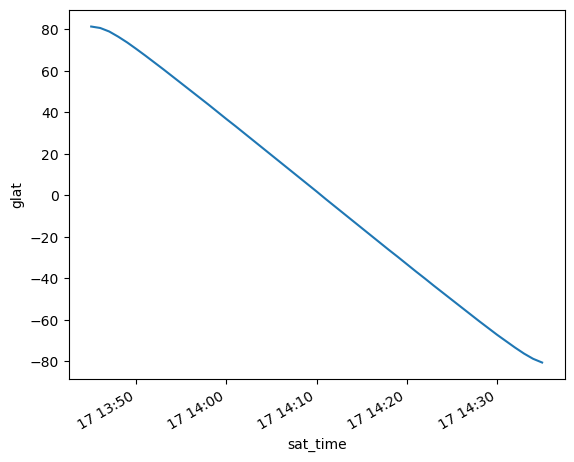

In [35]:
ds.glat.sel(sat_time=slice('2013-03-17 13:45', '2013-03-17 14:35')).plot()


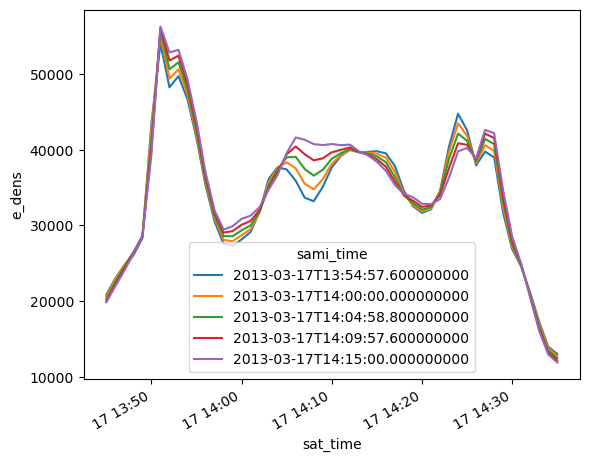

In [46]:
ds.e_dens.sel(sat_time=slice('2013-03-17 13:45', '2013-03-17 14:35'), sami_time=slice('2013-03-17 13:50', '2013-03-17 14:15')).plot.line(x='sat_time')

In [12]:
ds.e_dens.sum()

<xarray.DataArray 'e_dens' ()>
array(1.06906644e+11)